# Exploratory Data Analysis

### Imports

In [39]:
import os
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Reading sensor files

In [40]:
files = [file for file in os.listdir('../../Processed Sensors')]
files.sort()
read_files = []
for file in files:
    read_files.append(pd.read_csv('../../Processed Sensors/' + file))

### Removing sensors that don't appear across every user run

In [41]:
cols_file = [read_files[i].columns.tolist() for i in range(len(read_files))]
common_els = reduce(set.intersection, (set(item) for item in cols_file))
common_els = list(common_els)
read_files = [read_files[i][common_els] for i in range(len(read_files))]

### Reading the downtime data file and filtering out onlt the ion source failures

In [42]:
downtimeNew = pd.read_excel('../../Raw Data/Equipment downtime data (202310).xlsx')
downtimeNew['FaultDate'] = pd.to_datetime(downtimeNew['FaultDate'], errors='coerce').dt.date
downtimeNew['FaultTime'] = downtimeNew['FaultTime'].apply(lambda x: x.strftime('%H:%M:%S') if len(str(x)) > 8 else x)
downtimeNew = downtimeNew.dropna(subset=['FaultDate', 'FaultTime'])
pattern_new = downtimeNew.iloc[:, :14]
pattern_new = pattern_new.drop(['ID', 'DutyOfficer', 'Manager email address'], axis=1)
pattern_new['FaultDateTime'] = pd.to_datetime(pattern_new['FaultDate'].astype(str) + ' ' + pattern_new['FaultTime'].astype(str))
pattern_new.drop(['FaultDate', 'FaultTime'], axis=1, inplace=True)
pattern_new.sort_values(by=['FaultDateTime'], inplace=True)
pattern_new = pattern_new.drop(['LogEntry', 'DutyOfficer comments', 'Managerscomments', 'FaultRepair', 'FaultDescription', 'Group', 'Downtime'], axis=1)
pattern_new['Equipment'] = pattern_new['Equipment'].str.lower()
pattern_new['Equipment'] = pattern_new['Equipment'].str.replace('[^\w\s]', '')
pattern_new = pattern_new[pattern_new['Equipment'] == 'ion source']

### Integrating the fail points in the sensor files

In [43]:
userruns = ['18/04', '19/01', '19/02', '19/03', '20/01', '20/02', '20/03', '21/01', '21/02', '22/01', '22/02', '22/03', '22/04', '22/05', '23/01', '23/02', '23/03']
isrcFailRuns = [pattern_new[pattern_new['User Run'] == ur] for ur in userruns]

ct = 0
for i in range(len(read_files)):
    read_files[i]['Label'] = -1
    read_files[i]['failCount'] = ct
    read_files[i]['Time'] = pd.to_datetime(read_files[i]['Time'], format='%d/%m/%Y, %H:%M:%S')
    for j in range(read_files[i].shape[0]-1):
        read_files[i].loc[j, 'failCount'] = ct
        read_files[i].loc[j+1, 'failCount'] = ct
        for el in isrcFailRuns[i]['FaultDateTime']:
            if read_files[i]['Time'][j] <= el < read_files[i]['Time'][j+1]:
                read_files[i].loc[j, 'Label'] = 0   #['Label'][j] = 1
                ct+=1
                break

### Describe

In [44]:
print(read_files[0][read_files[0].columns.drop(['Time', 'Label', 'failCount'])].describe())

       irfq::gas:on  irfq::mag:read_current  irfq::solenoid_1:read_current  \
count  74881.000000            74881.000000                   74881.000000   
mean       0.768459                9.582905                     189.936713   
std        0.421820                0.270831                      31.655956   
min        0.000000                0.001952                       0.000000   
25%        1.000000                9.586760                     185.000000   
50%        1.000000                9.586760                     185.000000   
75%        1.000000                9.586760                     185.000000   
max        1.000000               13.780578                     370.000000   

       irfq::lebt:sta  irfq::gas:set_press  irfq::tran_ctrl:set_temp  \
count    74881.000000         74881.000000              74881.000000   
mean         0.955476             2.404750                299.486318   
std          0.206258             0.059017                 14.693024   
min      

### Plotting the sensor value change as bar plots 

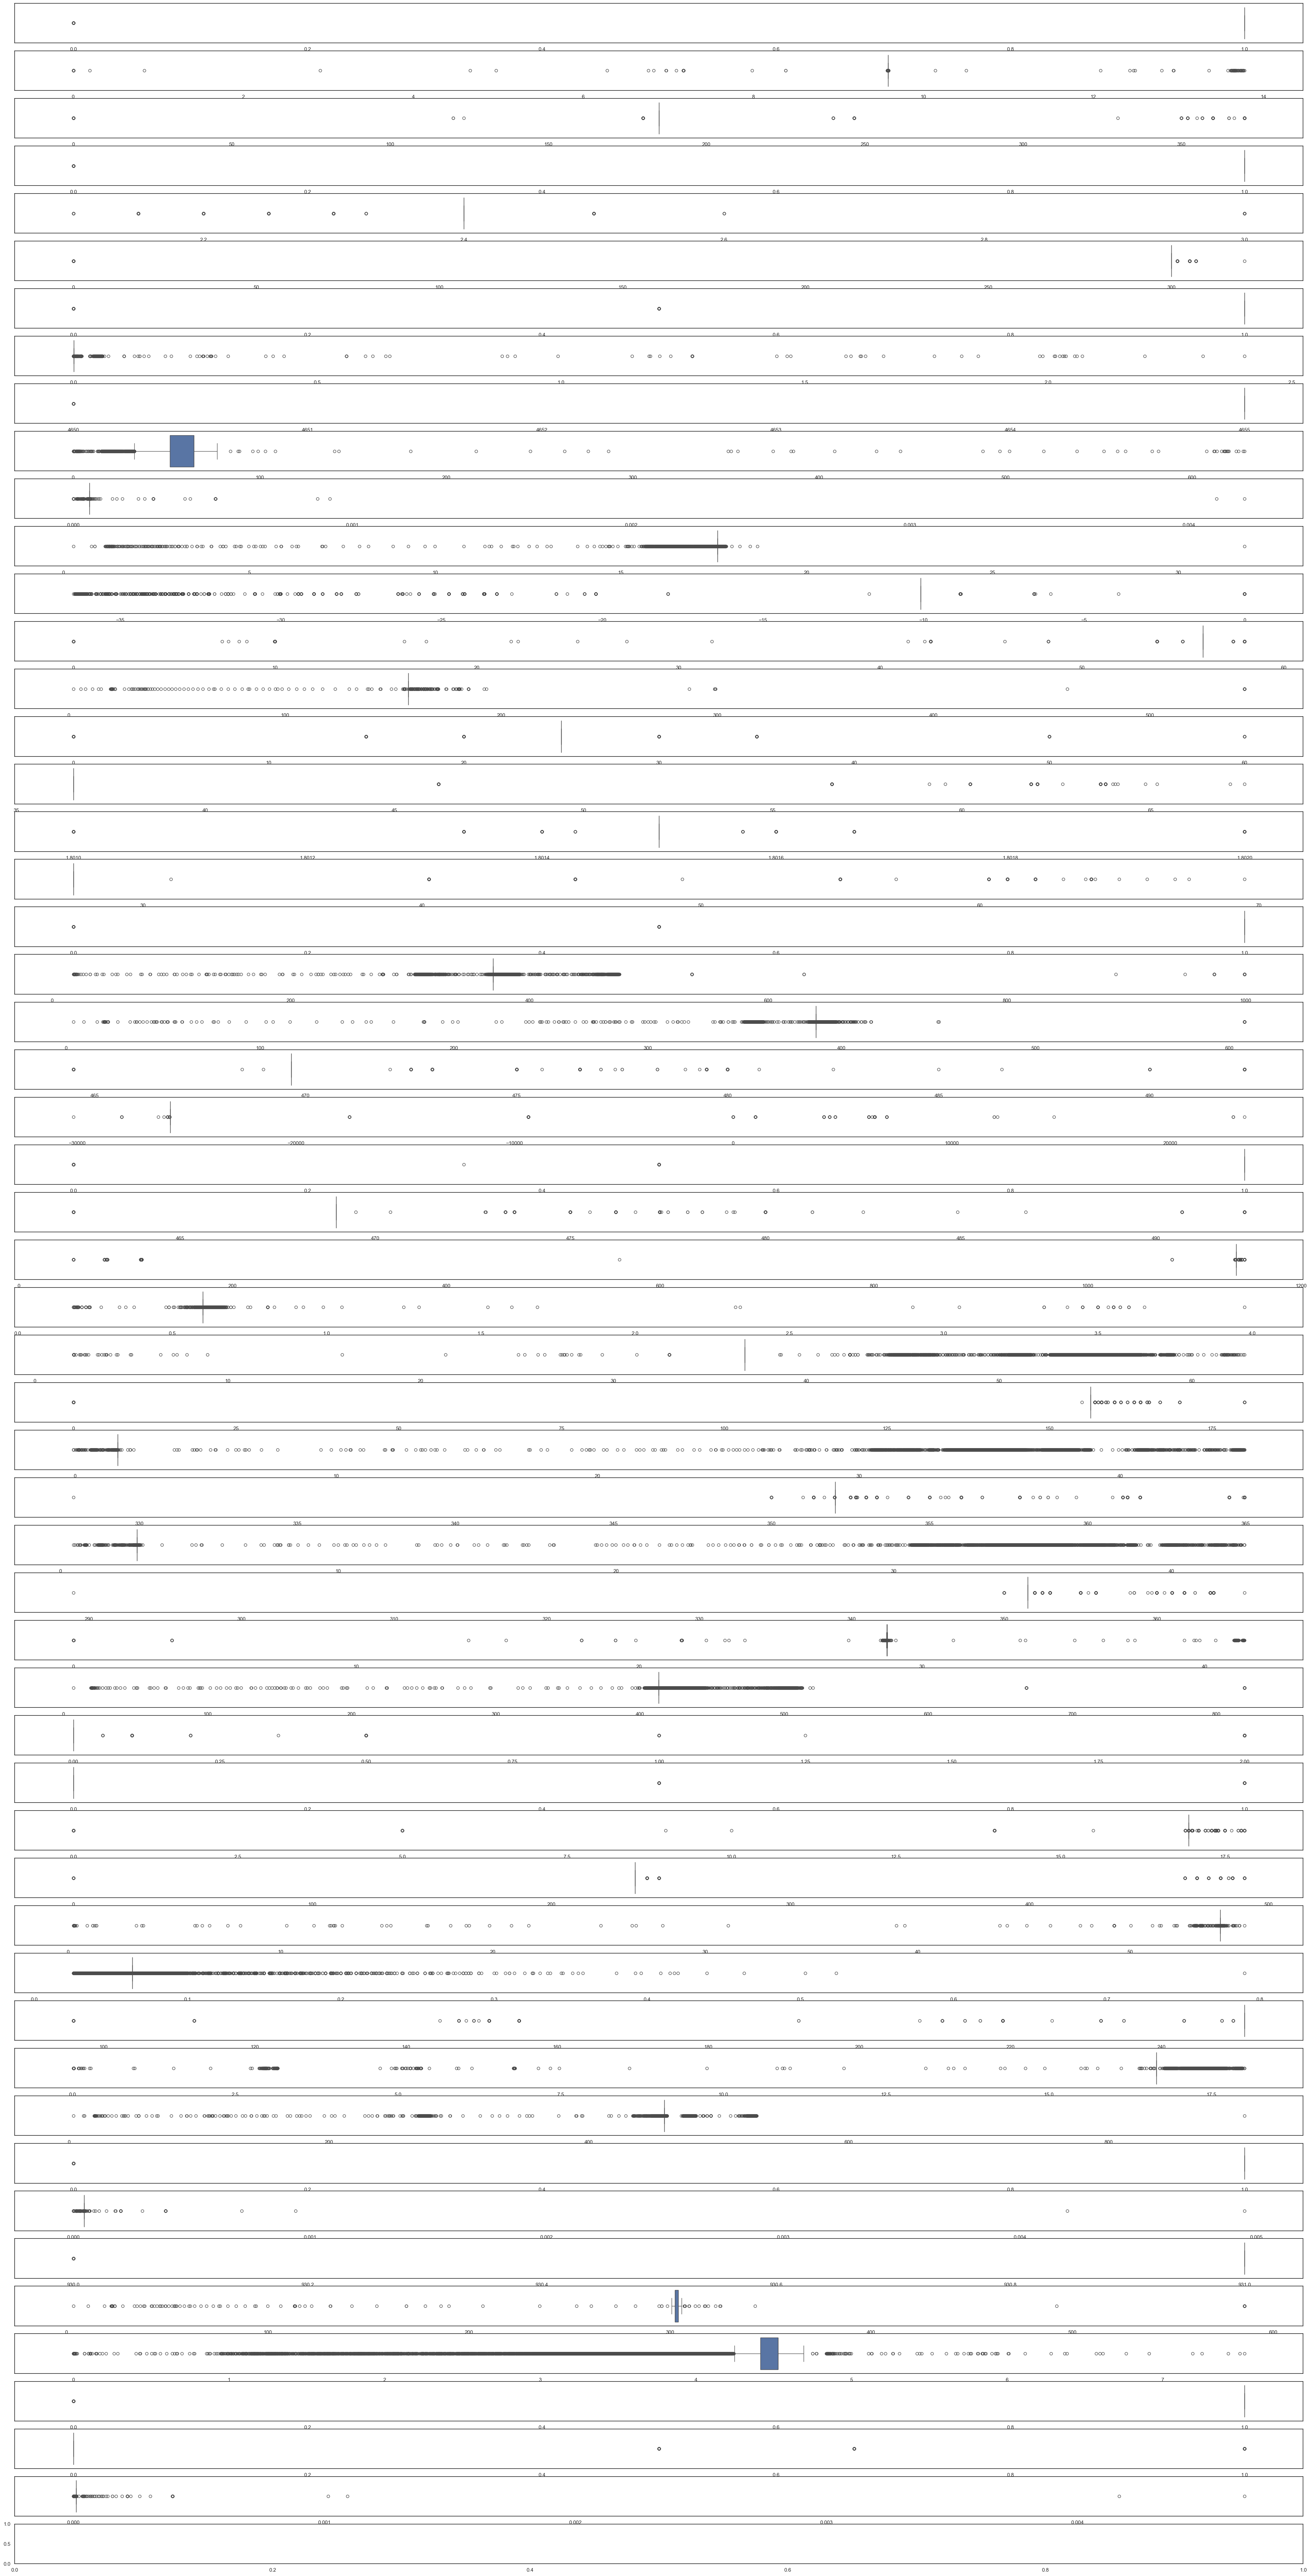

In [45]:
data = read_files[0].copy()

fig, ax = plt.subplots(54, 1,figsize=(50, 100))

for i,column in enumerate(data.columns.drop(['Time', 'Label', 'failCount'])):
    sns.boxplot(data=data, x = column, ax=ax.ravel()[i])

/var/folders/fy/y84g2yps4c9br5q9c1rlvy2h0000gn/T/ipykernel_840/3532922237.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=column, hue='failCount', palette='hls', ax=ax.ravel()[i], fill=True, legend=False)
/var/folders/fy/y84g2yps4c9br5q9c1rlvy2h0000gn/T/ipykernel_840/3532922237.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=column, hue='failCount', palette='hls', ax=ax.ravel()[i], fill=True, legend=False)
/var/folders/fy/y84g2yps4c9br5q9c1rlvy2h0000gn/T/ipykernel_840/3532922237.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=column, hue='failCount', palette='hls', ax=ax.ravel()[i], fill=True, legend=False)
/var/folders/fy/y84g2yps4c9br5q9c1rlvy2h0000gn/T/ipykernel_840/3532922237.py:4: Us

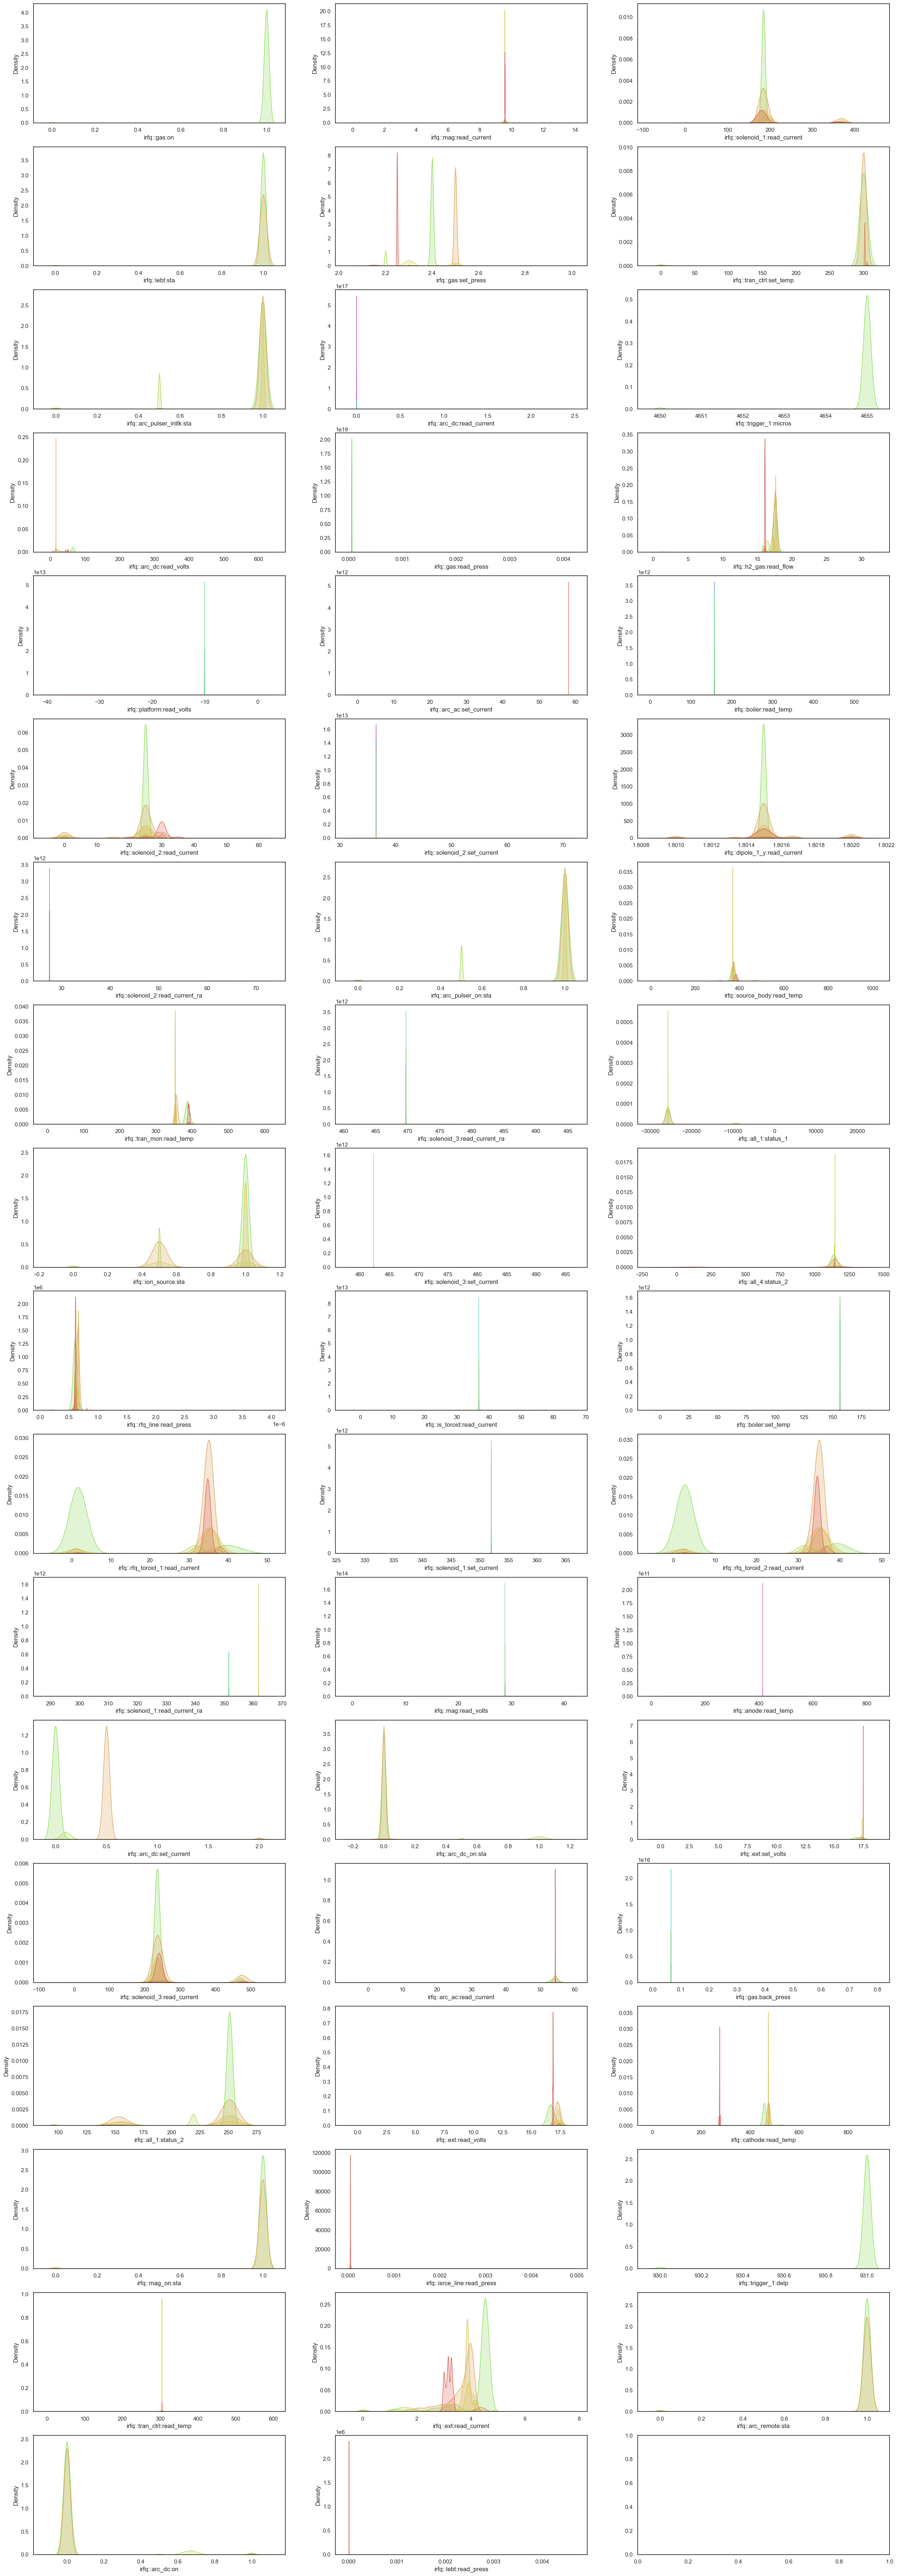

In [46]:
fig, ax = plt.subplots(18, 3,figsize=(30, 90))

for i,column in enumerate(data.columns.drop(['Time', 'Label', 'failCount'])):
    sns.kdeplot(data=data, x=column, hue='failCount', palette='hls', ax=ax.ravel()[i], fill=True, legend=False)

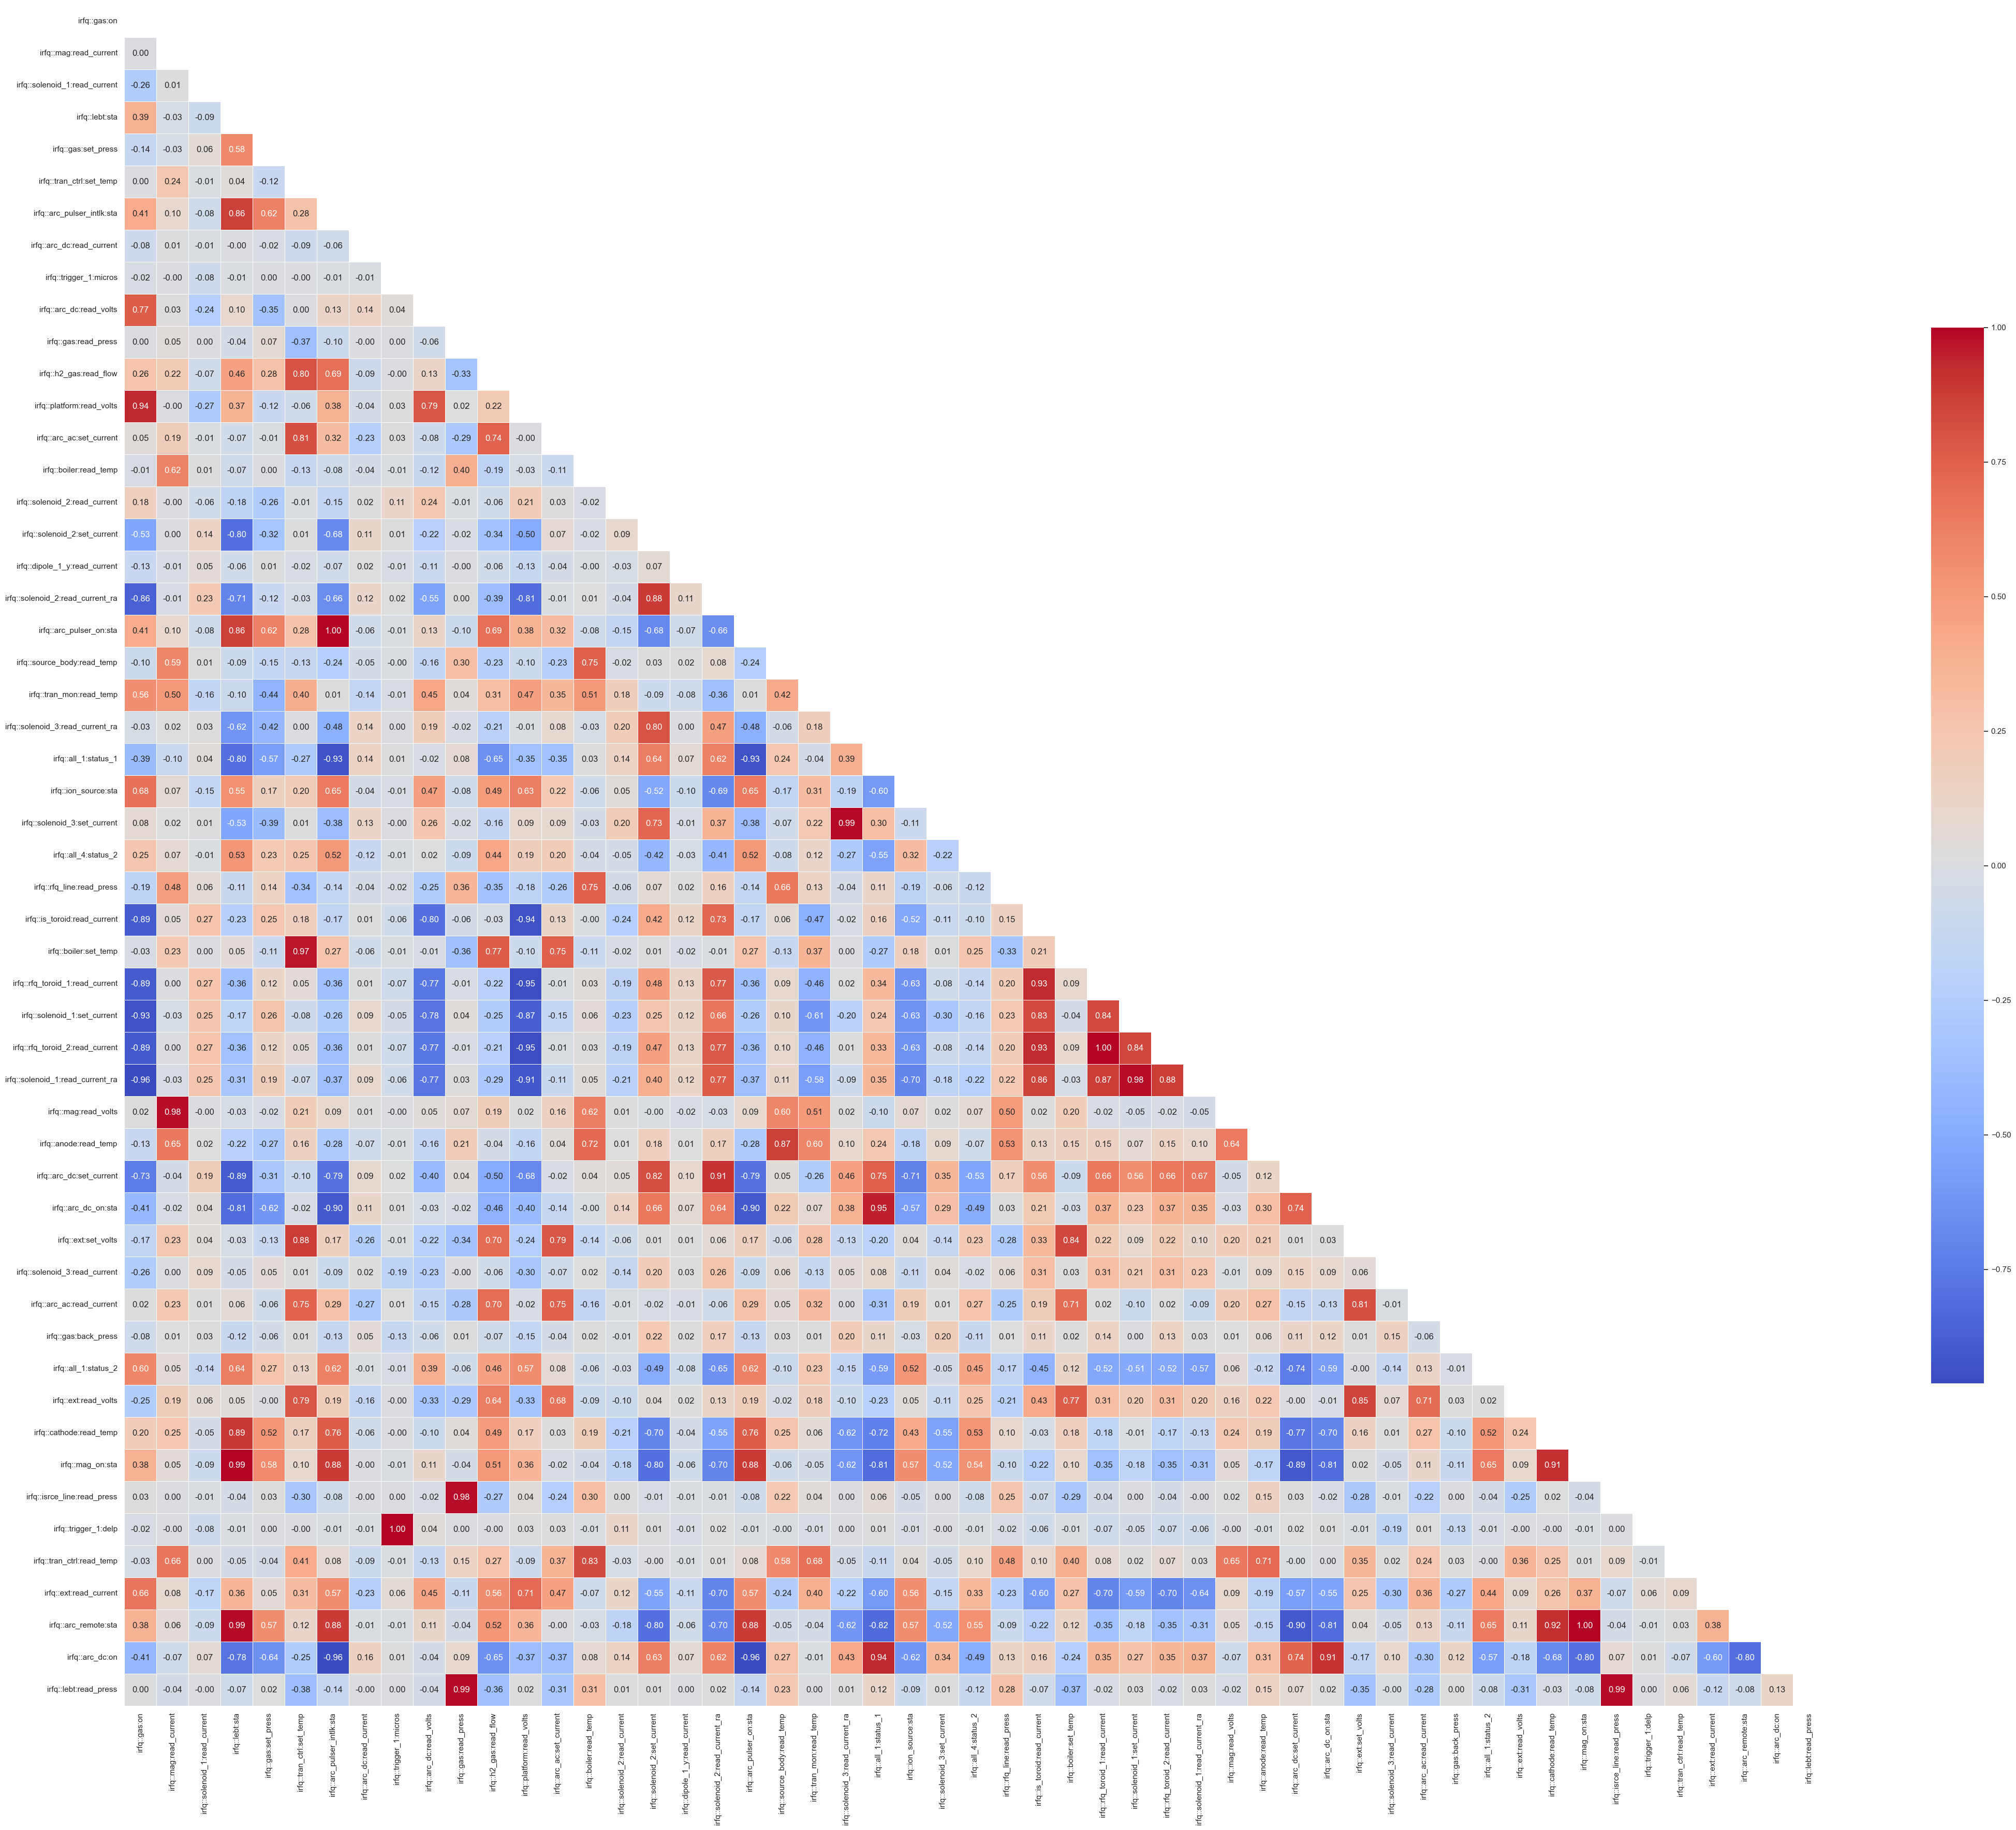

In [47]:
data = read_files[0][read_files[0].columns.drop(['Time', 'Label', 'failCount'])]

corr = data.corr()

sns.set(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(53, 53))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [48]:
corr_matrix = data.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
to_drop_neg = [column for column in upper_tri.columns if any(upper_tri[column] < -0.9)]

print(len(to_drop), to_drop)
print(len(to_drop_neg),to_drop_neg)

sett = set(to_drop + to_drop_neg)

16 ['irfq::platform:read_volts', 'irfq::arc_pulser_on:sta', 'irfq::solenoid_3:set_current', 'irfq::boiler:set_temp', 'irfq::rfq_toroid_1:read_current', 'irfq::rfq_toroid_2:read_current', 'irfq::solenoid_1:read_current_ra', 'irfq::mag:read_volts', 'irfq::arc_dc:set_current', 'irfq::arc_dc_on:sta', 'irfq::mag_on:sta', 'irfq::isrce_line:read_press', 'irfq::trigger_1:delp', 'irfq::arc_remote:sta', 'irfq::arc_dc:on', 'irfq::lebt:read_press']
7 ['irfq::all_1:status_1', 'irfq::is_toroid:read_current', 'irfq::rfq_toroid_1:read_current', 'irfq::solenoid_1:set_current', 'irfq::rfq_toroid_2:read_current', 'irfq::solenoid_1:read_current_ra', 'irfq::arc_dc:on']


In [49]:
print(len(sett), sett)

19 {'irfq::platform:read_volts', 'irfq::arc_pulser_on:sta', 'irfq::all_1:status_1', 'irfq::solenoid_3:set_current', 'irfq::boiler:set_temp', 'irfq::is_toroid:read_current', 'irfq::rfq_toroid_1:read_current', 'irfq::solenoid_1:set_current', 'irfq::rfq_toroid_2:read_current', 'irfq::solenoid_1:read_current_ra', 'irfq::mag:read_volts', 'irfq::arc_dc:set_current', 'irfq::arc_dc_on:sta', 'irfq::mag_on:sta', 'irfq::isrce_line:read_press', 'irfq::trigger_1:delp', 'irfq::arc_remote:sta', 'irfq::arc_dc:on', 'irfq::lebt:read_press'}


In [50]:
actual_data = read_files.copy()
actual_data
for i in range(len(actual_data)):
    actual_data[i].drop(to_drop, axis=1, inplace=True)

In [51]:
actual_data[0]

irfq::gas:on  irfq::mag:read_current  irfq::solenoid_1:read_current  \
0               0.0                 9.58676                          180.0   
1               0.0                 9.58188                          180.0   
2               0.0                 9.58432                          180.0   
3               0.0                 9.58188                          180.0   
4               0.0                 9.58188                          180.0   
...             ...                     ...                            ...   
74876           1.0                 9.58676                          185.0   
74877           1.0                 9.58676                          185.0   
74878           1.0                 9.58676                          185.0   
74879           1.0                 9.58676                          185.0   
74880           1.0                 9.58676                          185.0   

       irfq::lebt:sta  irfq::gas:set_press  irfq::tran_ctrl:set_temp  \
0                 0.0                 2.25                     305.0   
1                 0.0                 2.25                     305.0   
2                 0.0                 2.25                     305.0   
3                 0.0                 2.25                     305.0   
4                 0.0                 2.25                     305.0   
...               ...                  ...                       ...   
74876             1.0                 2.40                     300.0   
74877             1.0                 2.40                     300.0   
74878             1.0                 2.40                     300.0   
74879             1.0                 2.40                     300.0   
74880             1.0                 2.40                     300.0   

       irfq::arc_pulser_intlk:sta  irfq::arc_dc:read_current  \
0                             0.5                    0.00366   
1                             0.5                    0.00366   
2                             0.5                    0.00366   
3                             0.5                    0.00366   
4                             0.5                    0.00366   
...                           ...                        ...   
74876                         1.0                    0.00122   
74877                         1.0                    0.00122   
74878                         1.0                    0.00122   
74879                         1.0                    0.00122   
74880                         1.0                    0.00122   

       irfq::trigger_1:micros  irfq::arc_dc:read_volts  ...  \
0                      4655.0                51.728000  ...   
1                      4655.0                52.216000  ...   
2                      4655.0                51.955733  ...   
3                      4655.0                51.890666  ...   
4                      4655.0                51.850000  ...   
...                       ...                      ...  ...   
74876                  4655.0                64.660004  ...   
74877                  4655.0                64.660004  ...   
74878                  4655.0                64.660004  ...   
74879                  4655.0                64.660004  ...   
74880                  4655.0                64.660004  ...   

       irfq::solenoid_3:read_current  irfq::arc_ac:read_current  \
0                              240.0                  54.252291   
1                              240.0                  54.276986   
2                              240.0                  54.273225   
3                              240.0                  54.301386   
4                              240.0                  54.266820   
...                              ...                        ...   
74876                          235.0                  54.241199   
74877                          235.0                  54.241199   
74878                          235.0                  54.241199   
74879    

### Correlation Matrix with Thresholding
Instead of visualizing the full correlation matrix, you can set a threshold and only display correlations above or below that threshold. This can help focus on strong correlations.

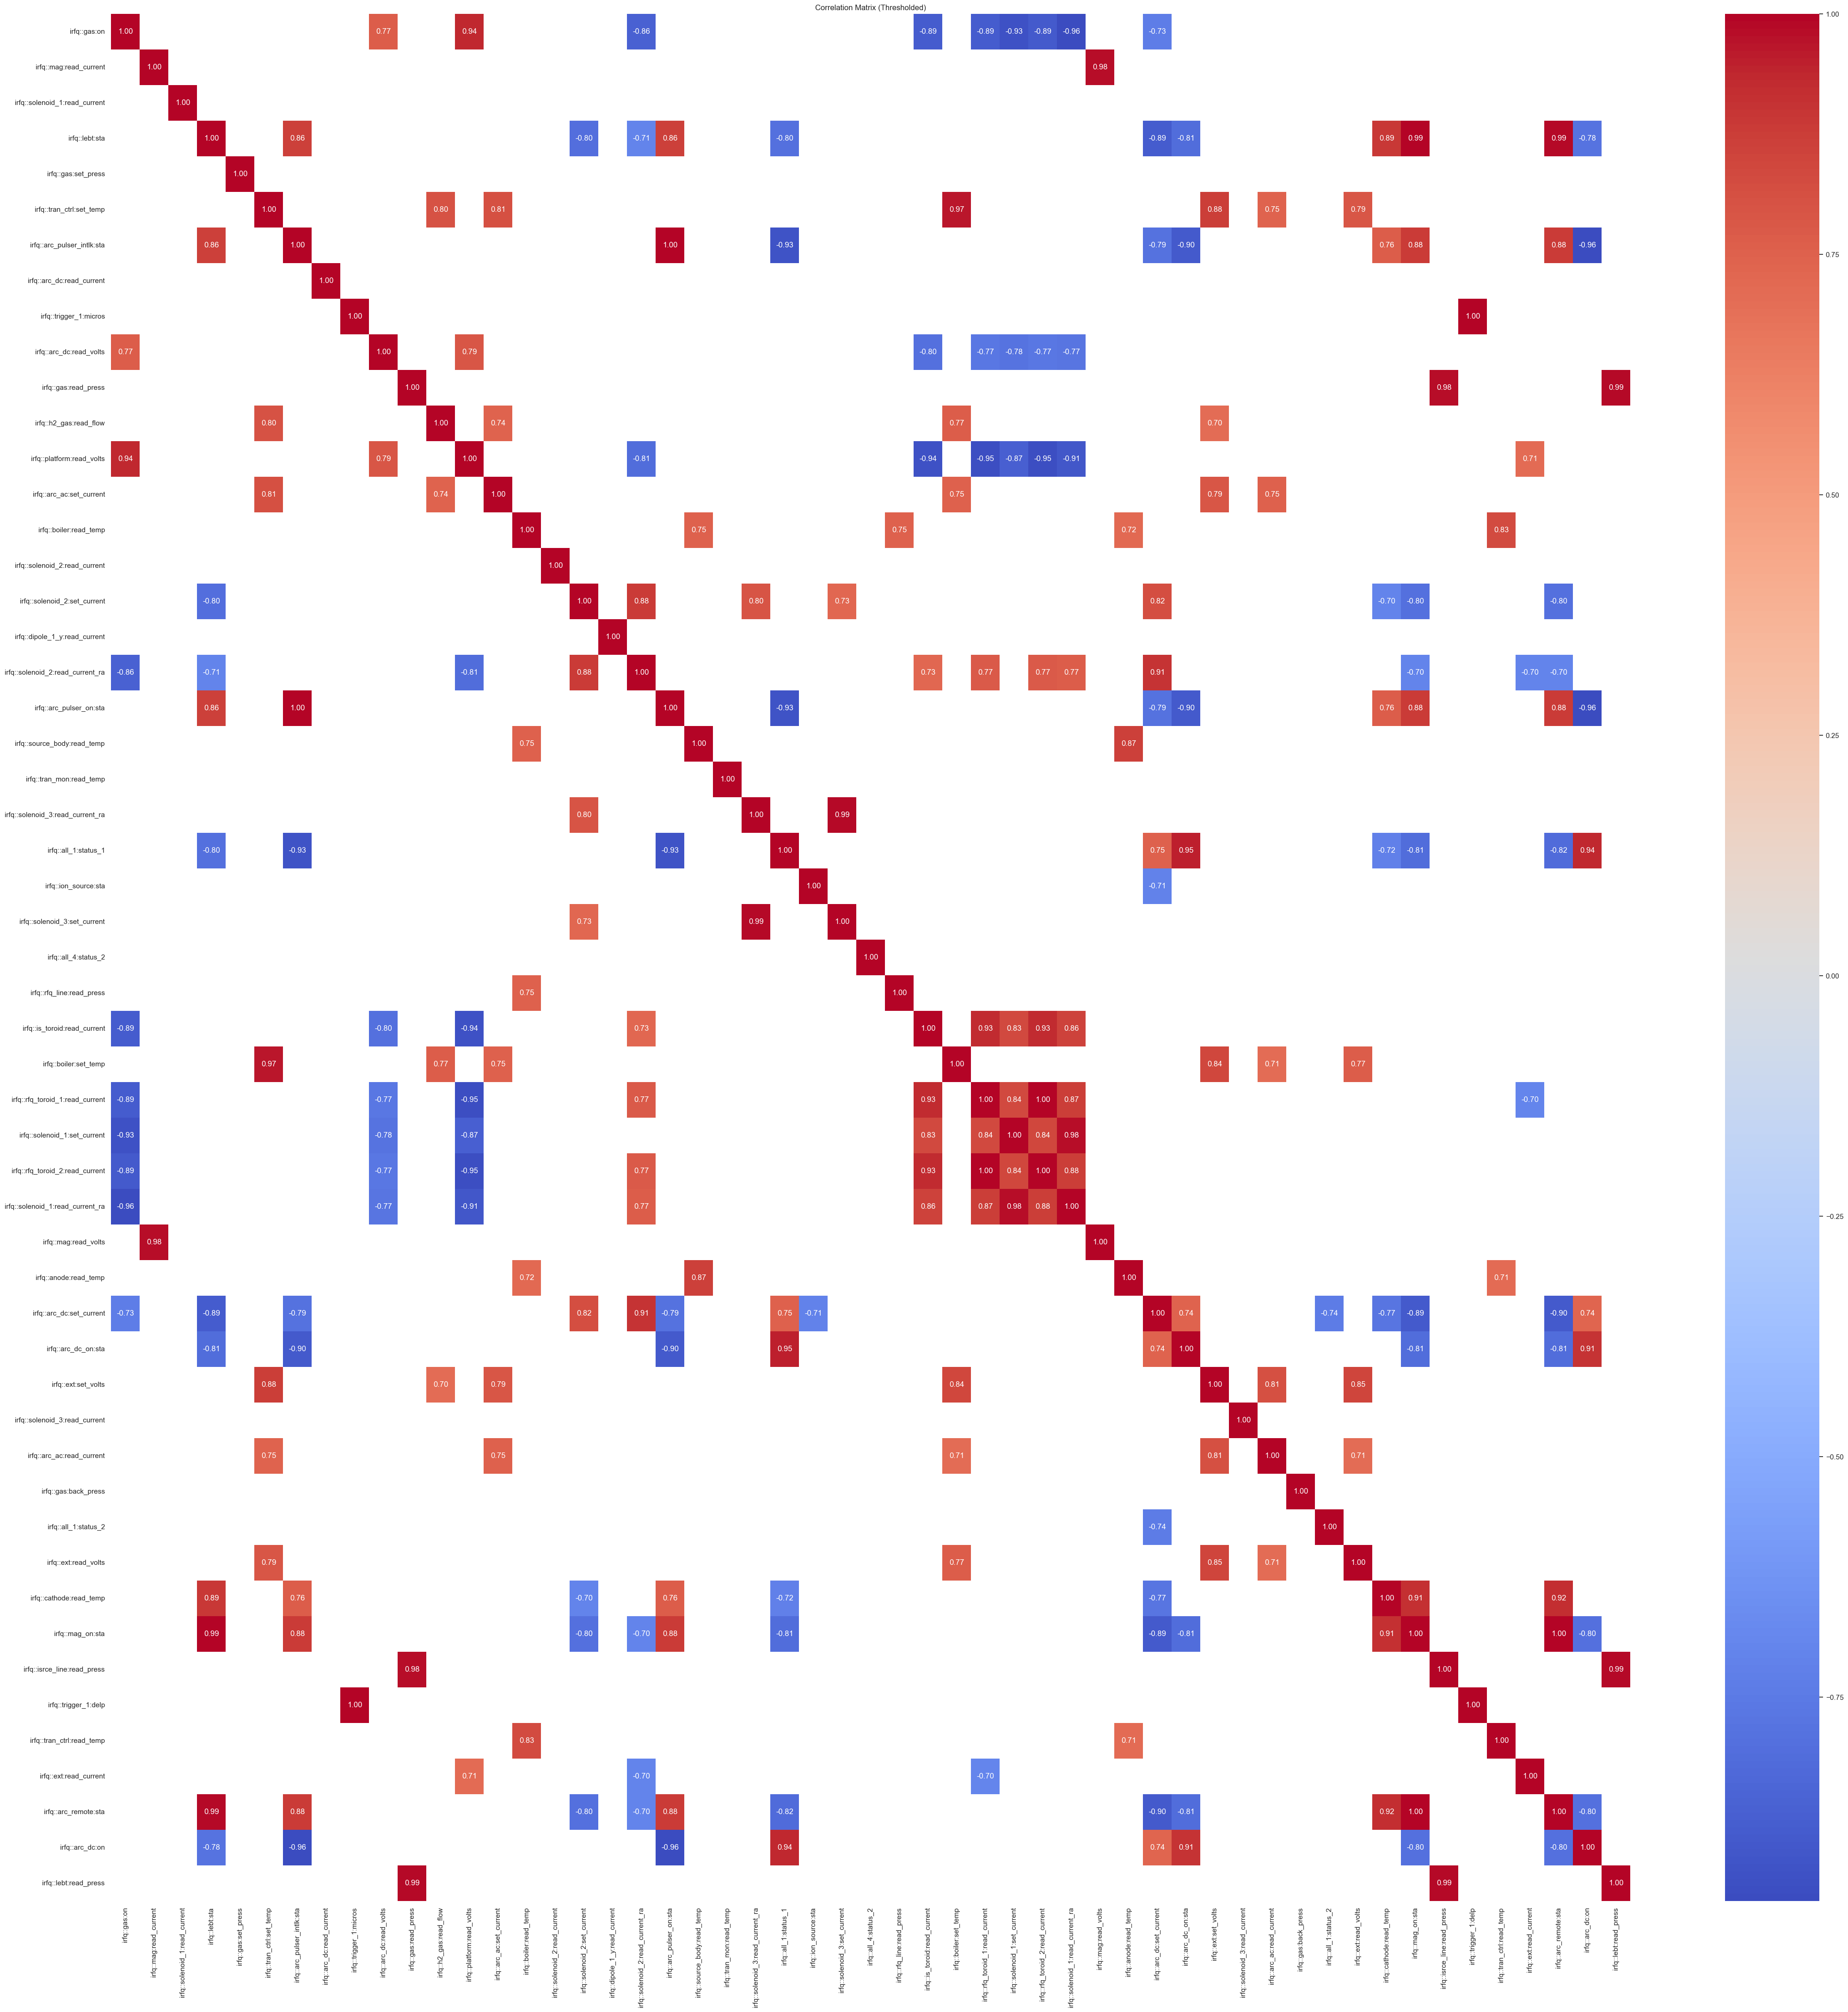

In [52]:
corr_matrix = data.corr()
high_corr = corr_matrix[abs(corr_matrix) > 0.7]  # Adjust threshold as needed
plt.figure(figsize=(53, 53))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Thresholded)')
plt.show()


### Hierarchical Clustering
used to group sensors based on their correlation patterns. This can help identify clusters of sensors that behave similarly.

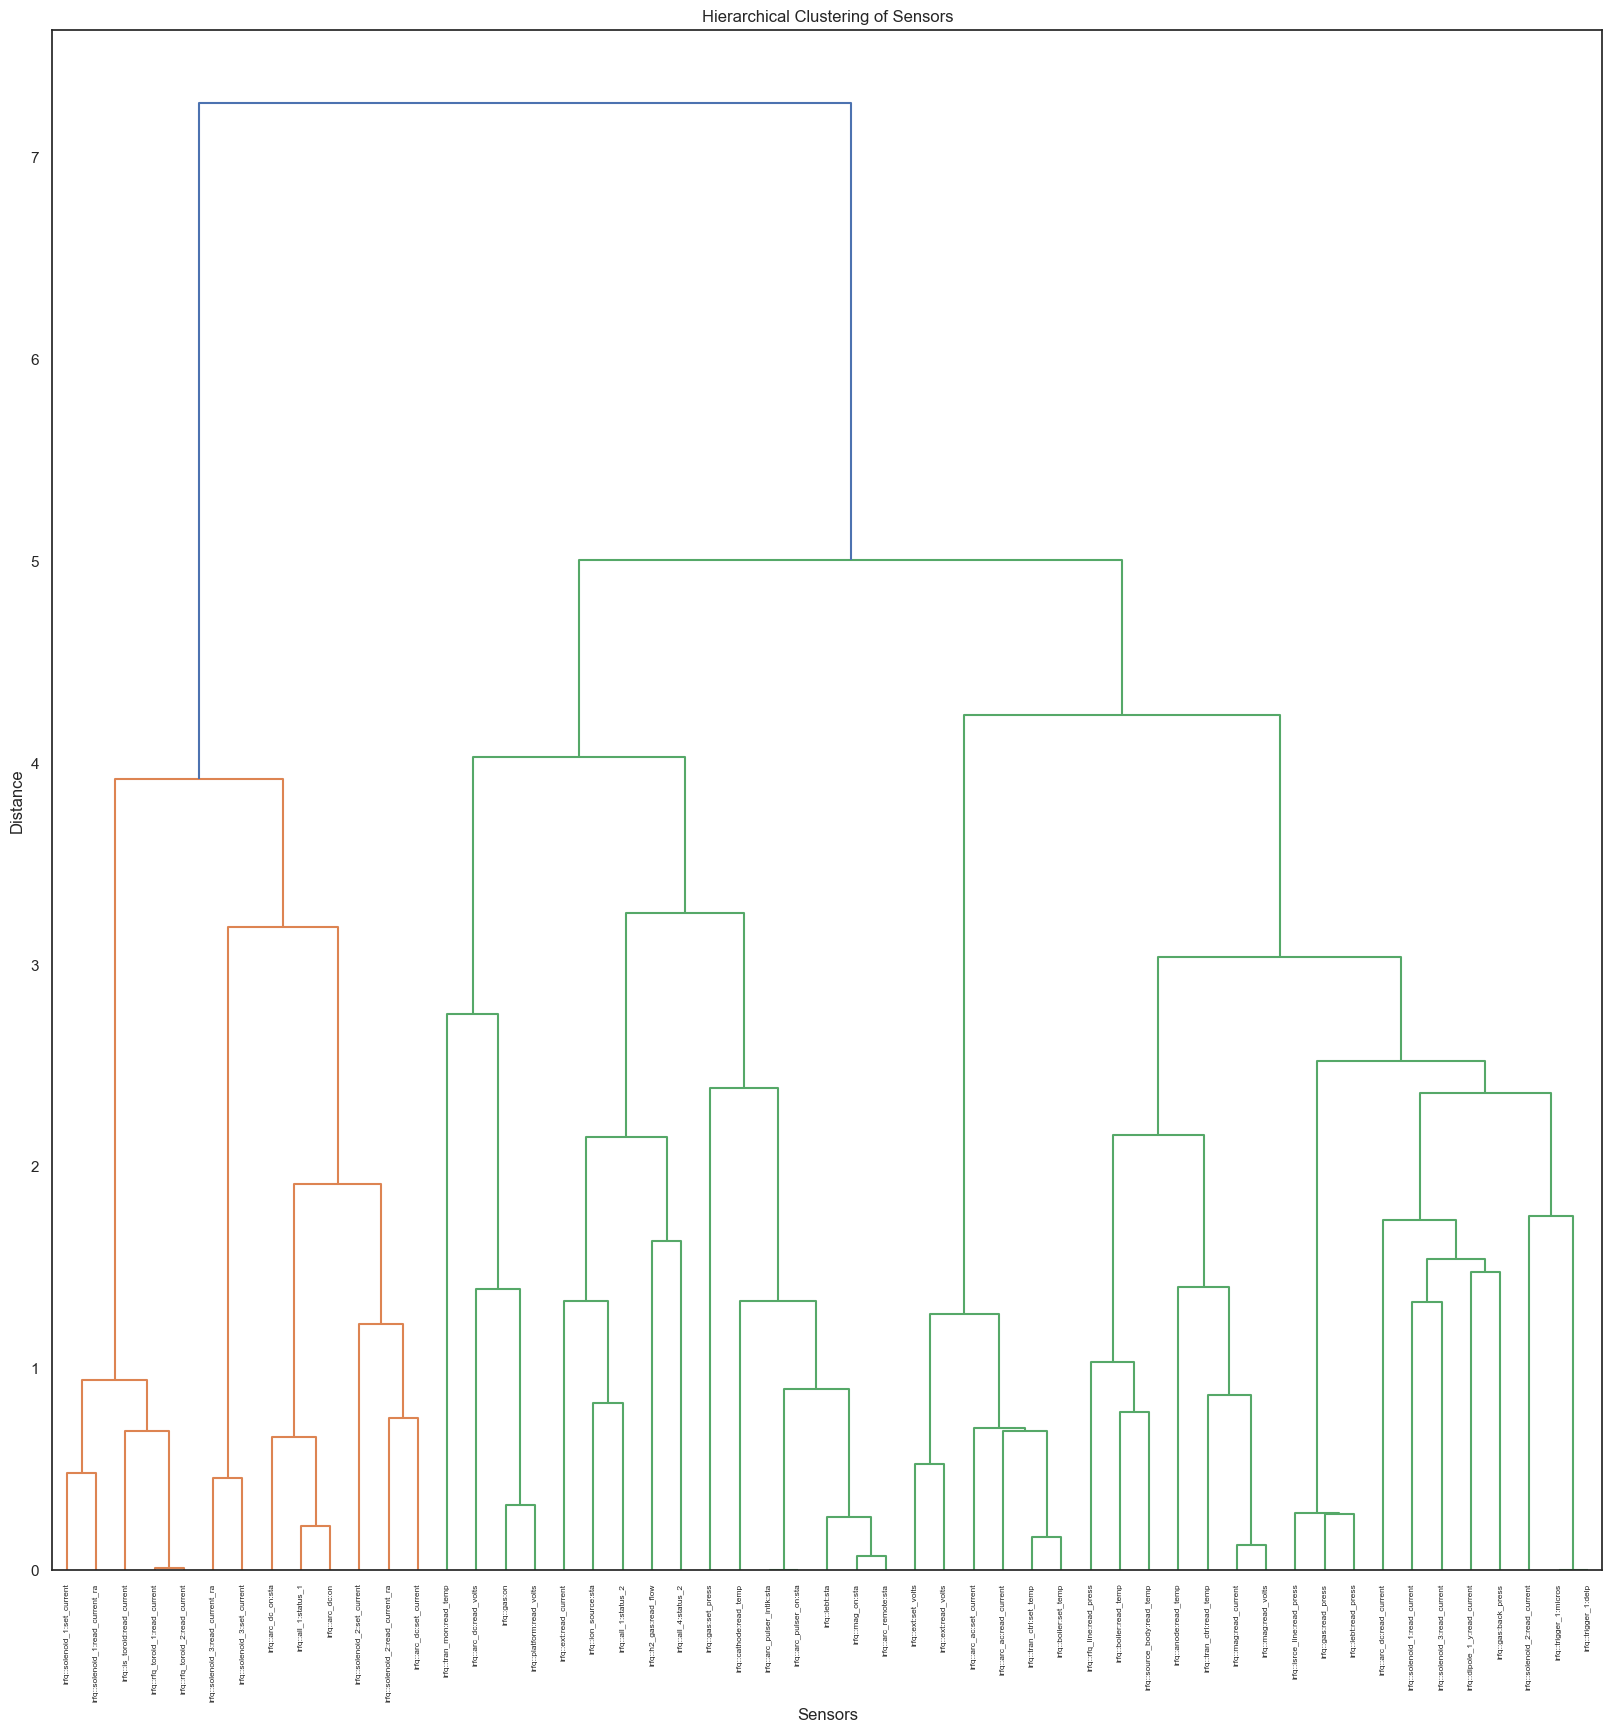

In [53]:
from scipy.cluster import hierarchy

corr_matrix = data.corr()
clustered_corr = hierarchy.linkage(corr_matrix, method='complete')
plt.figure(figsize=(20, 20))
dendrogram = hierarchy.dendrogram(clustered_corr, labels=corr_matrix.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering of Sensors')
plt.xlabel('Sensors')
plt.ylabel('Distance')
plt.show()


### Principal Component Analysis (PCA):
reduce the dimensionality of the feature space while preserving most of the variance. By examining the principal components, you can identify which sensors contribute most to the variation in the data.

In [54]:
# Concatenate sensor readings from all runs into a single dataframe
all_data = pd.concat(read_files)

# Drop unnecessary columns (if any)
# all_data = all_data.drop(['Time', 'failCount'], axis=1)

# Extract features (sensor readings) into feature matrix X
X = all_data.drop(['Label', 'Time', 'failCount'], axis=1)  # Assuming 'Label', 'Time', 'failCount' are not features

# Display the shape of the feature matrix
print("Shape of feature matrix X:", X.shape)

Shape of feature matrix X: (967697, 37)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


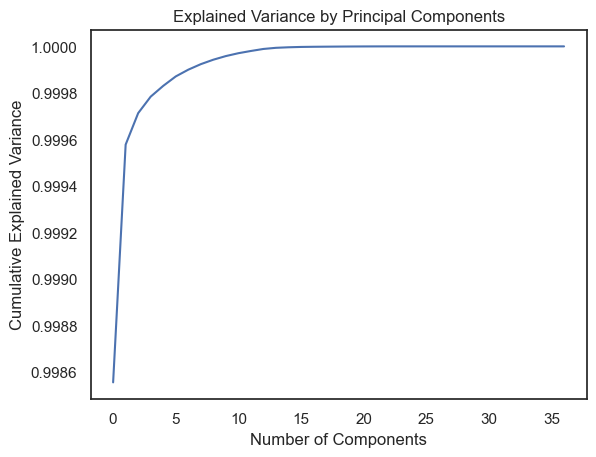

In [55]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)  # X is your feature matrix
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

In [56]:
# Select the first 5 components
selected_components = np.cumsum(explained_variance_ratio)[:5]
print("Cumulative Explained Variance for the first 5 components:", selected_components[-1])


Cumulative Explained Variance for the first 5 components: 0.9998301116421549


In [61]:
# Get the loading vectors for the first 5 components
loading_vectors = pca.components_[:10]

# Create a DataFrame to display the loading vectors
loading_df = pd.DataFrame(loading_vectors, columns=X.columns)

# Print the top 5 features for each component
for i, component in enumerate(loading_df.index):
    print(f"Top 5 features for Component {i+1}:")
    print(loading_df.iloc[i].nlargest(5))
    print()


Top 5 features for Component 1:
irfq::all_1:status_1                0.999974
irfq::boiler:read_temp              0.000846
irfq::solenoid_3:read_current_ra    0.000311
irfq::tran_ctrl:read_temp           0.000282
irfq::solenoid_1:set_current        0.000113
Name: 0, dtype: float64

Top 5 features for Component 2:
irfq::solenoid_3:read_current    0.034054
irfq::boiler:read_temp           0.026260
irfq::arc_dc:read_volts          0.011108
irfq::solenoid_1:read_current    0.009589
irfq::tran_ctrl:read_temp        0.009401
Name: 1, dtype: float64

Top 5 features for Component 3:
irfq::tran_ctrl:set_temp         0.981636
irfq::anode:read_temp            0.102755
irfq::all_1:status_2             0.099048
irfq::arc_ac:set_current         0.063551
irfq::solenoid_3:read_current    0.055336
Name: 2, dtype: float64

Top 5 features for Component 4:
irfq::tran_ctrl:set_temp         0.099799
irfq::boiler:read_temp           0.093928
irfq::tran_ctrl:read_temp        0.043010
irfq::solenoid_2:read_curr

takes roughly >15mins